<a href="https://colab.research.google.com/github/noorshehab/Life-of-a-showgirl-Sentiment-analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from huggingface_hub import login
login()
# %%
import torch
from sentence_transformers import SentenceTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "google/embeddinggemma-300M"
model = SentenceTransformer(model_id).to(device=device)

print(f"Device: {model.device}")
print(model)
print("Total number of parameters in the model:", sum([p.numel() for _, p in model.named_parameters()]))
# %%


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Device: cuda:0
SentenceTransformer(
  (0): Transformer({'max_seq_length': 2048, 'do_lower_case': False, 'architecture': 'Gemma3TextModel'})
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 3072, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (3): Dense({'in_features': 3072, 'out_features': 768, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
  (4): Normalize()
)
Total number of parameters in the model: 307581696


In [ ]:
import unicodedata
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:


df=pd.read_csv('labeled_swiftie_relevant.csv')
df=df[df['is_minimal']==True].copy()
df.head()

,Unnamed: 0,author/advertiser_account_type,author/analytics_type,author/can_dm,author/can_media_tag,author/created_at,author/description,author/favourites_count,author/followers_count,author/friends_count,...,tweet_mentions,tweet_hashtags,cleaned_tweet,is_reply,conversation_length,is_minimal,is_english,author_text,swiftie,relevant
0,0,promotable_user,enabled,False,False,Wed Aug 20 01:29:01 +0000 2014,"she/her | Taylor, BTS, Son Heung-Min & Spurs o...",146510,668,469,...,NaN,NaN,"Father Figure is 100% about Scott, and it's ab...",False,1,True,True,"₁₃𝓱𝓪𝔂𝓵𝓮𝔂 ⁷❤️‍🔥 SonnyVersion she/her | Taylor, ...",1,1
2,2,none,disabled,False,False,Mon May 17 11:22:44 +0000 2021,NaN,4579,335,149,...,NaN,NaN,msr x ruin the friendship,False,1,True,True,alix danascully4eva,0,1
3,3,none,disabled,False,True,Sun Sep 25 05:10:03 +0000 2022,NaN,29708,132,274,...,@cavalli_doll @HectorTorres214 @rossmacronald ...,NaN,An ugly lonely school shooter looking virg...,True,1,True,True,"Remy elkabeeeeee California, USA",0,1
4,4,promotable_user,enabled,False,True,Wed Dec 03 17:48:18 +0000 2008,Oasis Live '25,480,1577158,5,...,NaN,NaN,"Anyway, here’s… ‘Wonderwall (Unplugged)’!\nTak...",False,1,True,True,Oasis oasis London/Manchester Oasis Live '25,1,0
5,5,none,disabled,False,False,Sun Nov 06 01:01:49 +0000 2022,daisy edgar jones and josh o’connor this was a...,45560,831,468,...,NaN,NaN,what if i say ruin the friendship reminds me o...,False,1,True,True,lia daisysfilmss she/her daisy edgar jones and...,0,1


In [ ]:
#get the most popular tweets relevant and by swifties so 75th percentile of retweets
most_popular_tweets=df[df['retweet_count']>df['retweet_count'].quantile(0.75)]
most_popular_by_swifties=most_popular_tweets[most_popular_tweets['swiftie']==True]
most_popular_not_swiftie=most_popular_tweets[most_popular_tweets['swiftie']==False]

#generate the embeddings
top_swiftie=most_popular_by_swifties['cleaned_tweet'].tolist()
top_else=most_popular_not_swiftie['cleaned_tweet'].tolist()

top_swiftie_embeddings=model.encode(top_swiftie,prompt_name='Clustering')
top_else_embeddings=model.encode(top_else,prompt_name='Clustering')


In [ ]:
print(len(most_popular_by_swifties))

1143


In [ ]:

X_swiftie = np.array(top_swiftie_embeddings)
X_else   = np.array(top_else_embeddings)

group_swiftie = np.array(["swiftie"] * X_swiftie.shape[0])
group_else   = np.array(["else"]    * X_else.shape[0])

# Combine
X_all   = np.vstack([X_swiftie, X_else])
texts_all = top_swiftie+top_else
groups_all = np.concatenate([group_swiftie, group_else])

# 1. **Cluster in full 768-dim space**
scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(X_all)

db = DBSCAN(eps=2.0, min_samples=5)
cluster_labels = db.fit_predict(X_full_scaled)

# 2. **Project to 2D for visualization**
# Use PCA to reduce to e.g. 50 dims first (to speed up), then TSNE to 2D
pca = PCA(n_components=50, random_state=42)
X_pca50 = pca.fit_transform(X_full_scaled)

tsne = TSNE(n_components=2, random_state=42, init="pca", perplexity=30)
X2 = tsne.fit_transform(X_pca50)

# 3. Scale plotting coordinates (optional)
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 4. Build DataFrame
df_vis = pd.DataFrame({
    "x": cluster_labels.astype(int) * 0 + X2_scaled[:, 0],  # just x-coord
    "y": X2_scaled[:, 1],
    "cluster": cluster_labels.astype(str),
    "group": groups_all,
    "text": texts_all
})

# 5. Visualize with Plotly
fig = px.scatter(
    df_vis,
    x="x",
    y="y",
    color="cluster",
    symbol="group",
    hover_data=["text", "group"],
    title="Clustering in 768-D then 2D projection (hover over points)"
)
fig.update_traces(marker=dict(size=6, opacity=0.7))
fig.show()
#export the figure

In [ ]:
#generate labels
subjects=['The Life of A Showgirl commercial,chart,sales,views performance',
          'The Life of a Showgirl musical quality',
          'Opinion of Individual Songs on Taylor Swifts The life of a Showgirl',
          'Comparison of the life of a showgirl to other Taylor Swift work',
          'Comparison of Taylor Swift to other artists',
          'Discussion of the recording, production ,and writing of The Life of A Showgirl',
          'Discussion of Taylor Swift']

sentiments=['Positive','Negative']
tone=['Support','Ridicule']

#get all the relevant tweets
relevant_tweets=df[df['relevant']==True].copy()
relevant_tweets = relevant_tweets.reset_index(drop=True)
relevant_tweets_text=relevant_tweets['cleaned_tweet'].tolist()

#use the model to label them
subjects_embeddings=model.encode(subjects,prompt_name='Classification')
tone_embeddings=model.encode(tone,prompt_name='Classification')
sentiments_embeddings=model.encode(sentiments,prompt_name='Classification')
relevant_tweets_embeddings=model.encode(relevant_tweets_text,prompt_name='Classification')

def get_label(embedding,label_embeddings,labels):
  similarities = model.similarity(embedding, label_embeddings)
  max_similarity=np.argmax(similarities)
  return labels[max_similarity]

subjects_labels=[get_label(embedding,subjects_embeddings,subjects) for embedding in relevant_tweets_embeddings]
tone_labels=[get_label(embedding,tone_embeddings,tone) for embedding in relevant_tweets_embeddings]
sentiments_labels=[get_label(embedding,sentiments_embeddings,sentiments) for embedding in relevant_tweets_embeddings]

relevant_tweets['subject']=subjects_labels
relevant_tweets['tone']=tone_labels
relevant_tweets['sentiment']=sentiments_labels




In [ ]:
print(relevant_tweets.head())

   Unnamed: 0 author/advertiser_account_type author/analytics_type  \
0           0                promotable_user               enabled   
1           2                           none              disabled   
2           3                           none              disabled   
3           5                           none              disabled   
4           6                           none              disabled   

   author/can_dm  author/can_media_tag               author/created_at  \
0          False                 False  Wed Aug 20 01:29:01 +0000 2014   
1          False                 False  Mon May 17 11:22:44 +0000 2021   
2          False                  True  Sun Sep 25 05:10:03 +0000 2022   
3          False                 False  Sun Nov 06 01:01:49 +0000 2022   
4           True                  True  Thu Apr 29 19:43:12 +0000 2021   

                                  author/description  author/favourites_count  \
0  she/her | Taylor, BTS, Son Heung-Min & Spurs o... 

In [ ]:
#plot results

subject_counts = relevant_tweets["subject"].value_counts().reset_index()
subject_counts.columns = ["subject", "count"]

# Add a percentage column
subject_counts["pct"] = subject_counts["count"] / subject_counts["count"].sum()

# Interactive bar chart for subjects
fig_subj = px.bar(
    subject_counts,
    x="subject",
    y="count",
    text=subject_counts["pct"].apply(lambda x: f"{x:.1%}"),
    hover_data=["pct"],
    title="Distribution of subjects among relevant tweets"
)
fig_subj.update_traces(textposition="outside")
fig_subj.update_layout(xaxis_tickangle=-45, yaxis_title="Count of tweets", xaxis_title="Subject")
fig_subj.show()




In [ ]:


for subj_name in subjects:
    df_subj = relevant_tweets[relevant_tweets["subject"] == subj_name].copy()
    if df_subj.empty:
        print(f"No tweets for subject \"{subj_name}\" → skipping.")
        continue

    # Extract indices, embeddings for this subset
    positions = df_subj.index.to_numpy()  # this is label-index but ideally we reset first
    X_full = relevant_tweets_embeddings[positions, :] # shape (m, 768)
    texts= df_subj["cleaned_tweet"].tolist()
    tones= df_subj["tone"].tolist()
    sents= df_subj["sentiment"].tolist()
    swiftie= df_subj["swiftie"].tolist()

    # Dimensionality reduction: PCA → TSNE for good 2D layout
    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X_full)
    tsne = TSNE(n_components=2, random_state=42, init="pca", perplexity=30)
    X2   = tsne.fit_transform(X_pca)

       # Prepare DataFrame for plotting
    df_vis = pd.DataFrame({
        "x":        X2[:, 0],
        "y":        X2[:, 1],
        "cleaned_tweet": texts,
        "tone":      tones,
        "sentiment": sents,
        'swiftie': swiftie
    })

    # Create the scatter using px.scatter (color by tone initially)
    fig = px.scatter(
        df_vis,
        x="x",
        y="y",
        color="sentiment",                     # initial colouring by tone
        hover_data=["cleaned_tweet","sentiment","tone",'swiftie'],
        title=f"{subj_name}"
    )

    fig.update_layout(xaxis_title=" ", yaxis_title=" ")

    fig.show()

Mean sentiment_score by reply status:
is_reply
False    0.087965
True    -0.105023
Name: sentiment_score, dtype: float64

Mean tone_score by reply status:
is_reply
False    0.010919
True    -0.086758
Name: tone_score, dtype: float64

Mean sentiment_score by quote status:
is_quote_status
False    0.078518
True    -0.107832
Name: sentiment_score, dtype: float64

Mean tone_score by quote status:
is_quote_status
False    0.010252
True    -0.128263
Name: tone_score, dtype: float64

T-test sentiment: replies vs non-replies → p = 0.0000
T-test tone: replies vs non-replies → p = 0.0010

T-test sentiment: quotes vs non-quotes → p = 0.0000
T-test tone: quotes vs non-quotes → p = 0.0001

Mean sentiment_score by is_swiftie:
swiftie
0   -0.01210
1    0.16827
Name: sentiment_score, dtype: float64

Mean tone_score by is_swiftie:
swiftie
0   -0.062278
1    0.084525
Name: tone_score, dtype: float64

T-test sentiment: swiftie vs non-swiftie → p = 0.0000
T-test tone: swiftie vs non-swiftie → p = 0.0000



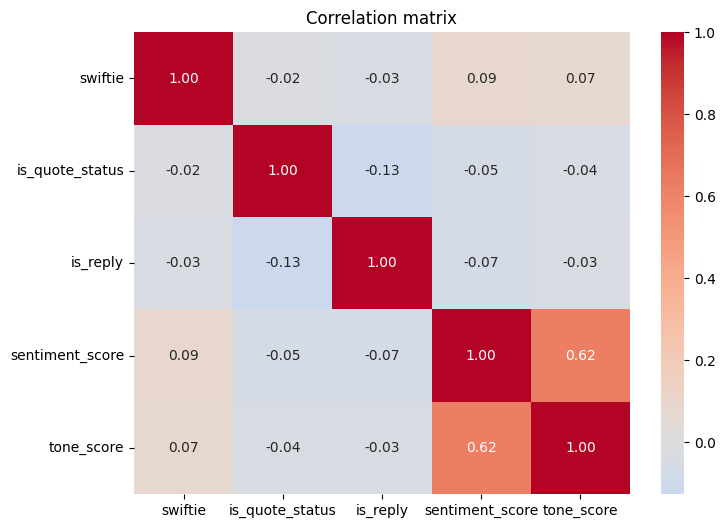

In [ ]:
#likes and retweets are agreement replies and quotes are disagreement
#are the sentiments and tones in replies and quotes more negative
relevant_tweets["sentiment_score"] = relevant_tweets["sentiment"].map({"Positive": +1, "Negative": -1})
relevant_tweets["tone_score"]= relevant_tweets["tone"].map({"Support": +1, "Ridicule": -1})

#Descriptive statistics for replies vs non-replies
print("Mean sentiment_score by reply status:")
print(relevant_tweets.groupby("is_reply")["sentiment_score"].mean())
print("\nMean tone_score by reply status:")
print(relevant_tweets.groupby("is_reply")["tone_score"].mean())

print("\nMean sentiment_score by quote status:")
print(relevant_tweets.groupby("is_quote_status")["sentiment_score"].mean())
print("\nMean tone_score by quote status:")
print(relevant_tweets.groupby("is_quote_status")["tone_score"].mean())

#T-tests: are replies more negative / less supportive?
reply_sentiment = relevant_tweets[relevant_tweets["is_reply"] == True]["sentiment_score"]
nonreply_sent    = relevant_tweets[relevant_tweets["is_reply"] == False]["sentiment_score"]
t_stat_s, p_val_s = ttest_ind(reply_sentiment.dropna(), nonreply_sent.dropna(), equal_var=False)
print(f"\nT-test sentiment: replies vs non-replies → p = {p_val_s:.4f}")

reply_tone = relevant_tweets[relevant_tweets["is_reply"] == True]["tone_score"]
nonreply_tone = relevant_tweets[relevant_tweets["is_reply"] == False]["tone_score"]
t_stat_t, p_val_t = ttest_ind(reply_tone.dropna(), nonreply_tone.dropna(), equal_var=False)
print(f"T-test tone: replies vs non-replies → p = {p_val_t:.4f}")

#T-tests are quotes more negative / less supportive?
quote_sentiment=relevant_tweets[relevant_tweets['is_quote_status']==True]['sentiment_score']
nonquote_sent=relevant_tweets[relevant_tweets['is_quote_status']==False]['sentiment_score']
t_stat_s2, p_val_s2 = ttest_ind(quote_sentiment.dropna(), nonquote_sent.dropna(), equal_var=False)
print(f"\nT-test sentiment: quotes vs non-quotes → p = {p_val_s2:.4f}")

quote_tone=relevant_tweets[relevant_tweets['is_quote_status']==True]['tone_score']
nonquote_tone=relevant_tweets[relevant_tweets['is_quote_status']==False]['tone_score']
t_stat_t2, p_val_t2 = ttest_ind(quote_tone.dropna(), nonquote_tone.dropna(), equal_var=False)
print(f"T-test tone: quotes vs non-quotes → p = {p_val_t2:.4f}")

# Compare Swifties vs Not Swifties
print("\nMean sentiment_score by is_swiftie:")
print(relevant_tweets.groupby("swiftie")["sentiment_score"].mean())
print("\nMean tone_score by is_swiftie:")
print(relevant_tweets.groupby("swiftie")["tone_score"].mean())

swiftie_sent = relevant_tweets[relevant_tweets["swiftie"] == True]["sentiment_score"]
nonsw_sent   = relevant_tweets[relevant_tweets["swiftie"] == False]["sentiment_score"]
t_s2, p_s2 = ttest_ind(swiftie_sent.dropna(), nonsw_sent.dropna(), equal_var=False)
print(f"\nT-test sentiment: swiftie vs non-swiftie → p = {p_s2:.4f}")

swiftie_tone = relevant_tweets[relevant_tweets["swiftie"] == True]["tone_score"]
nonsw_tone   = relevant_tweets[relevant_tweets["swiftie"] == False]["tone_score"]
t_t2, p_t2 = ttest_ind(swiftie_tone.dropna(), nonsw_tone.dropna(), equal_var=False)
print(f"T-test tone: swiftie vs non-swiftie → p = {p_t2:.4f}")

# Correlation analysis
corr_df = relevant_tweets[[
    "swiftie",
    'is_quote_status',
    'is_reply',
    "sentiment_score",
    "tone_score"
]].corr(method="pearson")
print("\nCorrelation matrix:")
print(corr_df)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation matrix")
plt.show()

In [ ]:
#so we can confidently say quotes and replies are more negative so despite not having each tweets direct replies and each tweets quotes thats a reasonable assumption
#lets look at positive engagement likes and retweets
#embed for scentence similarity
# df we want as result
#df {subject,sentiment,tone,author_followers,retweet_count,reply_count,is_reply,is_quote,like_count,quote_count,embedding,swiftie}
#how similar are the opinions of the most popular swiftie accounts to the opinions of the least popular
#how similar are the opinions of the least popular non swiftie accounts to the most

subject_interesting=['The Life of a Showgirl musical quality',
          'Opinion of Individual Songs on Taylor Swifts The life of a Showgirl',
          'Comparison of the life of a showgirl to other Taylor Swift work',
          'Comparison of Taylor Swift to other artists','Discussion of Taylor Swift']

interesting_tweets=relevant_tweets[relevant_tweets['subject'].isin(subject_interesting)].copy()

#embed for clustering
embeddings_list = model.encode(interesting_tweets['cleaned_tweet'].tolist(),prompt_name='STS')

# Store embeddings in a dictionary with tweet IDs as keys
embeddings = {tweet_id: embedding for tweet_id, embedding in zip(interesting_tweets['id'], embeddings_list)}

In [ ]:
interesting_tweets["engagement_score"] = interesting_tweets["retweet_count"] + interesting_tweets["favorite_count"]
top_pct = 95  # top 5%
cutoff = np.percentile(interesting_tweets["engagement_score"], top_pct)
interesting_tweets["high_engagement"] = interesting_tweets["engagement_score"] >= cutoff

#Identify top popular accounts
followers_cutoff = np.percentile(interesting_tweets["author/followers_count"], 90)  # top 10%
interesting_tweets["popular_account"] = interesting_tweets["author/followers_count"] >= followers_cutoff

high_engagement_ids = interesting_tweets[interesting_tweets['high_engagement'] == True]['id'].tolist()
popular_ids = interesting_tweets[interesting_tweets['popular_account'] == True]['id'].tolist()

high_engagement_tweets = [embeddings[t_id] for t_id in high_engagement_ids if t_id in embeddings]
popular_tweets = [embeddings[t_id] for t_id in popular_ids if t_id in embeddings]

# Convert lists of embeddings to numpy arrays for easier calculation
high_engagement_embeddings_np = np.array(high_engagement_tweets)
popular_embeddings_np = np.array(popular_tweets)

def calculate_max_similarity(embedding, reference_embeddings_np, reference_ids):
    if reference_embeddings_np.shape[0] == 0:
        return None, None  # Return None if there are no reference embeddings
    # Calculate cosine similarity between one embedding and a set of embeddings
    # Normalize embeddings first
    embedding_norm = embedding / np.linalg.norm(embedding)
    reference_embeddings_norm = reference_embeddings_np / np.linalg.norm(reference_embeddings_np, axis=1, keepdims=True)

    # Calculate dot products (cosine similarity)
    similarities = np.dot(reference_embeddings_norm, embedding_norm)

    max_sim_index = np.argmax(similarities)
    max_sim_score = similarities[max_sim_index]
    corresponding_id = reference_ids[max_sim_index]

    return max_sim_score, corresponding_id


# Calculate maximum similarity to high engagement tweets for each interesting tweet
max_similarity_to_high_engagement = []
id_max_similarity_engagement=[]
for tweet_id in interesting_tweets['id']:
    embedding = embeddings[tweet_id]
    max_sim, corresponding_id = calculate_max_similarity(embedding, high_engagement_embeddings_np, high_engagement_ids)
    max_similarity_to_high_engagement.append(max_sim)
    id_max_similarity_engagement.append(corresponding_id)

interesting_tweets['id_max_similarity_engagement'] = id_max_similarity_engagement
interesting_tweets['max_similarity_to_high_engagement'] = max_similarity_to_high_engagement


# Calculate maximum similarity to popular tweets for each interesting tweet
max_similarity_to_popular = []
id_max_similarity_popular=[]
for tweet_id in interesting_tweets['id']:
    embedding = embeddings[tweet_id]
    max_sim, corresponding_id = calculate_max_similarity(embedding, popular_embeddings_np, popular_ids)
    max_similarity_to_popular.append(max_sim)
    id_max_similarity_popular.append(corresponding_id)

interesting_tweets['max_similarity_to_popular'] = max_similarity_to_popular
interesting_tweets['id_max_similarity_popular'] = id_max_similarity_popular

Sample similar tweet pairs (Interesting Tweet vs. High Engagement Tweet):


IndexError: invalid index to scalar variable.

In [ ]:
# Count how many interesting tweets are most similar to each high engagement tweet
high_engagement_similarity_counts = interesting_tweets['id_max_similarity_engagement'].value_counts().reset_index()
high_engagement_similarity_counts.columns = ['high_engagement_tweet_id', 'count_of_similar_interesting_tweets']

print("Count of interesting tweets most similar to each high engagement tweet:")
display(high_engagement_similarity_counts)

# Count how many interesting tweets are most similar to each popular tweet
popular_similarity_counts = interesting_tweets['id_max_similarity_popular'].value_counts().reset_index()
popular_similarity_counts.columns = ['popular_tweet_id', 'count_of_similar_interesting_tweets']

print("\nCount of interesting tweets most similar to each popular tweet:")
display(popular_similarity_counts)

Count of interesting tweets most similar to each high engagement tweet:


,high_engagement_tweet_id,count_of_similar_interesting_tweets
0,1.974062e+18,402
1,1.973969e+18,225
2,1.974977e+18,216
3,1.973964e+18,189
4,1.974161e+18,164
...,...,...
456,1.974093e+18,1
457,1.974282e+18,1
458,1.974569e+18,1
459,1.973970e+18,1



Count of interesting tweets most similar to each popular tweet:


,popular_tweet_id,count_of_similar_interesting_tweets
0,1.973970e+18,365
1,1.973932e+18,176
2,1.973972e+18,159
3,1.974621e+18,116
4,1.974119e+18,92
...,...,...
908,1.974826e+18,1
909,1.974030e+18,1
910,1.974089e+18,1
911,1.974973e+18,1


from matplotlib import pyplot as plt
high_engagement_similarity_counts['high_engagement_tweet_id'].plot(kind='hist', bins=20, title='high_engagement_tweet_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
high_engagement_similarity_counts['count_of_similar_interesting_tweets'].plot(kind='hist', bins=20, title='count_of_similar_interesting_tweets')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
high_engagement_similarity_counts.plot(kind='scatter', x='high_engagement_tweet_id', y='count_of_similar_interesting_tweets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
high_engagement_similarity_counts['high_engagement_tweet_id'].plot(kind='line', figsize=(8, 4), title='high_engagement_tweet_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
high_engagement_similarity_counts['count_of_similar_interesting_tweets'].plot(kind='line', figsize=(8, 4), title='count_of_similar_interesting_tweets')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
popular_similarity_counts['popular_tweet_id'].plot(kind='hist', bins=20, title='popular_tweet_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
popular_similarity_counts['count_of_similar_interesting_tweets'].plot(kind='hist', bins=20, title='count_of_similar_interesting_tweets')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
popular_similarity_counts.plot(kind='scatter', x='popular_tweet_id', y='count_of_similar_interesting_tweets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
popular_similarity_counts['popular_tweet_id'].plot(kind='line', figsize=(8, 4), title='popular_tweet_id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
popular_similarity_counts['count_of_similar_interesting_tweets'].plot(kind='line', figsize=(8, 4), title='count_of_similar_interesting_tweets')
plt.gca().spines[['top', 'right']].set_visible(False)

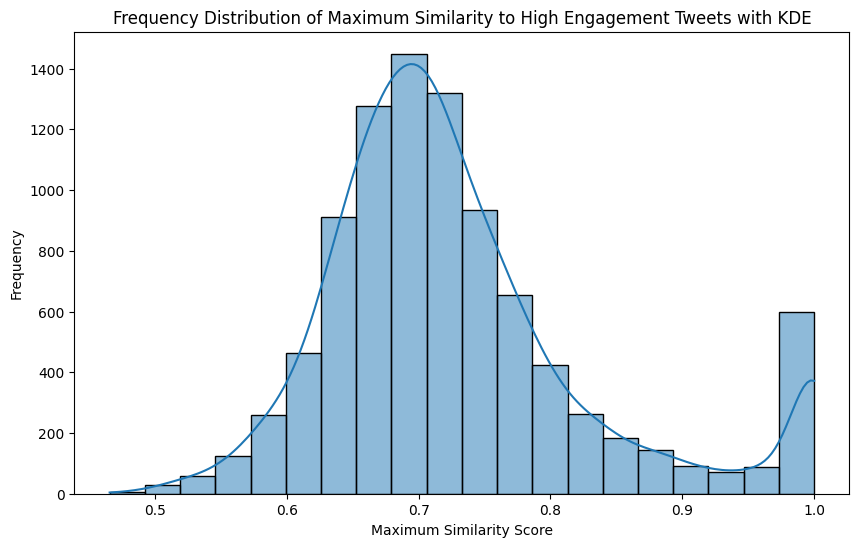

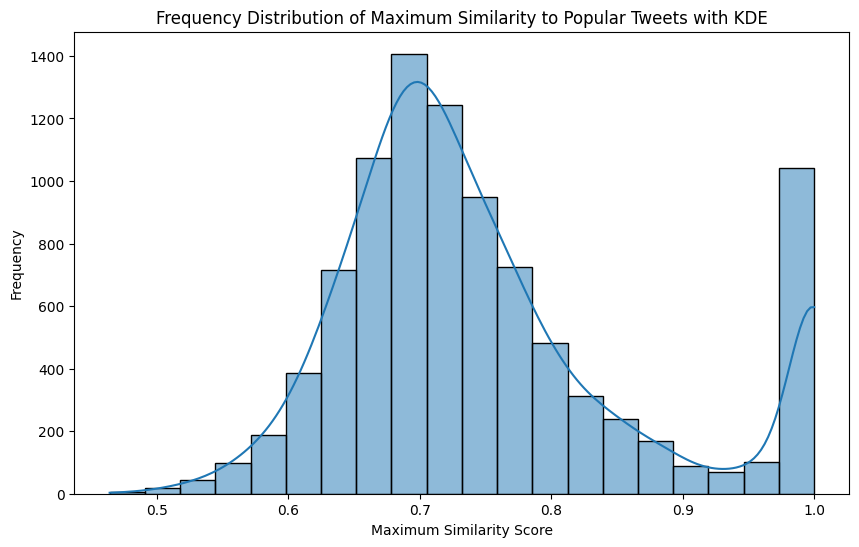

In [ ]:


# Extract the similarity scores
high_engagement_similarity_scores = interesting_tweets['max_similarity_to_high_engagement']
popular_similarity_scores = interesting_tweets['max_similarity_to_popular']

# Create frequency histogram with density curve for high engagement similarity scores

plt.figure(figsize=(10, 6))
sns.histplot(high_engagement_similarity_scores, kde=True, bins=20)
plt.title('Frequency Distribution of Maximum Similarity to High Engagement Tweets with KDE')
plt.xlabel("Maximum Similarity Score")
plt.ylabel("Frequency")
plt.show()


# Create frequency histogram with density curve for popular similarity scores

plt.figure(figsize=(10, 6))
sns.histplot(popular_similarity_scores, kde=True, bins=20) # Adjust bins as needed
plt.title('Frequency Distribution of Maximum Similarity to Popular Tweets with KDE')
plt.xlabel("Maximum Similarity Score")
plt.ylabel("Frequency")
plt.show()


In [ ]:
interesting_tweets.to_csv('interesting_tweets.csv')